In [1]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib import colors
from metpy.plots.ctables import registry
from metpy.plots import colortables
from metpy.plots import USCOUNTIES
from metpy.units import units
from siphon.catalog import TDSCatalog
import xarray as xr

In [2]:
######
# Sector 07 = Shortwave IR
# Sector 13 = Longwave IR
######

CHANNEL = '07'

# Choices are 'Mesoscale-1', 'Mesoscale-2', 'CONUS', or 'FullDisk'
SECTOR = 'Mesoscale-2'

# Time Parameters
FRAME_START = 72
FRAME_INTERVAL = -5

In [3]:
# Scan the catalog and download the data
def get_satellite(sector, channel, frame):
    satcat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                        f'CloudAndMoistureImagery/{sector}/Channel{channel}/current/catalog.xml')
    dataset = satcat.datasets[frame]
    dataset = dataset.remote_access(use_xarray=True)
    return dataset

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

In [4]:
# Store satellite time-series data in a tuple
datasets = ()

for frame in range(FRAME_START, -1, FRAME_INTERVAL):
    ds = get_satellite(SECTOR, CHANNEL, frame)
    datasets = (*datasets, ds)

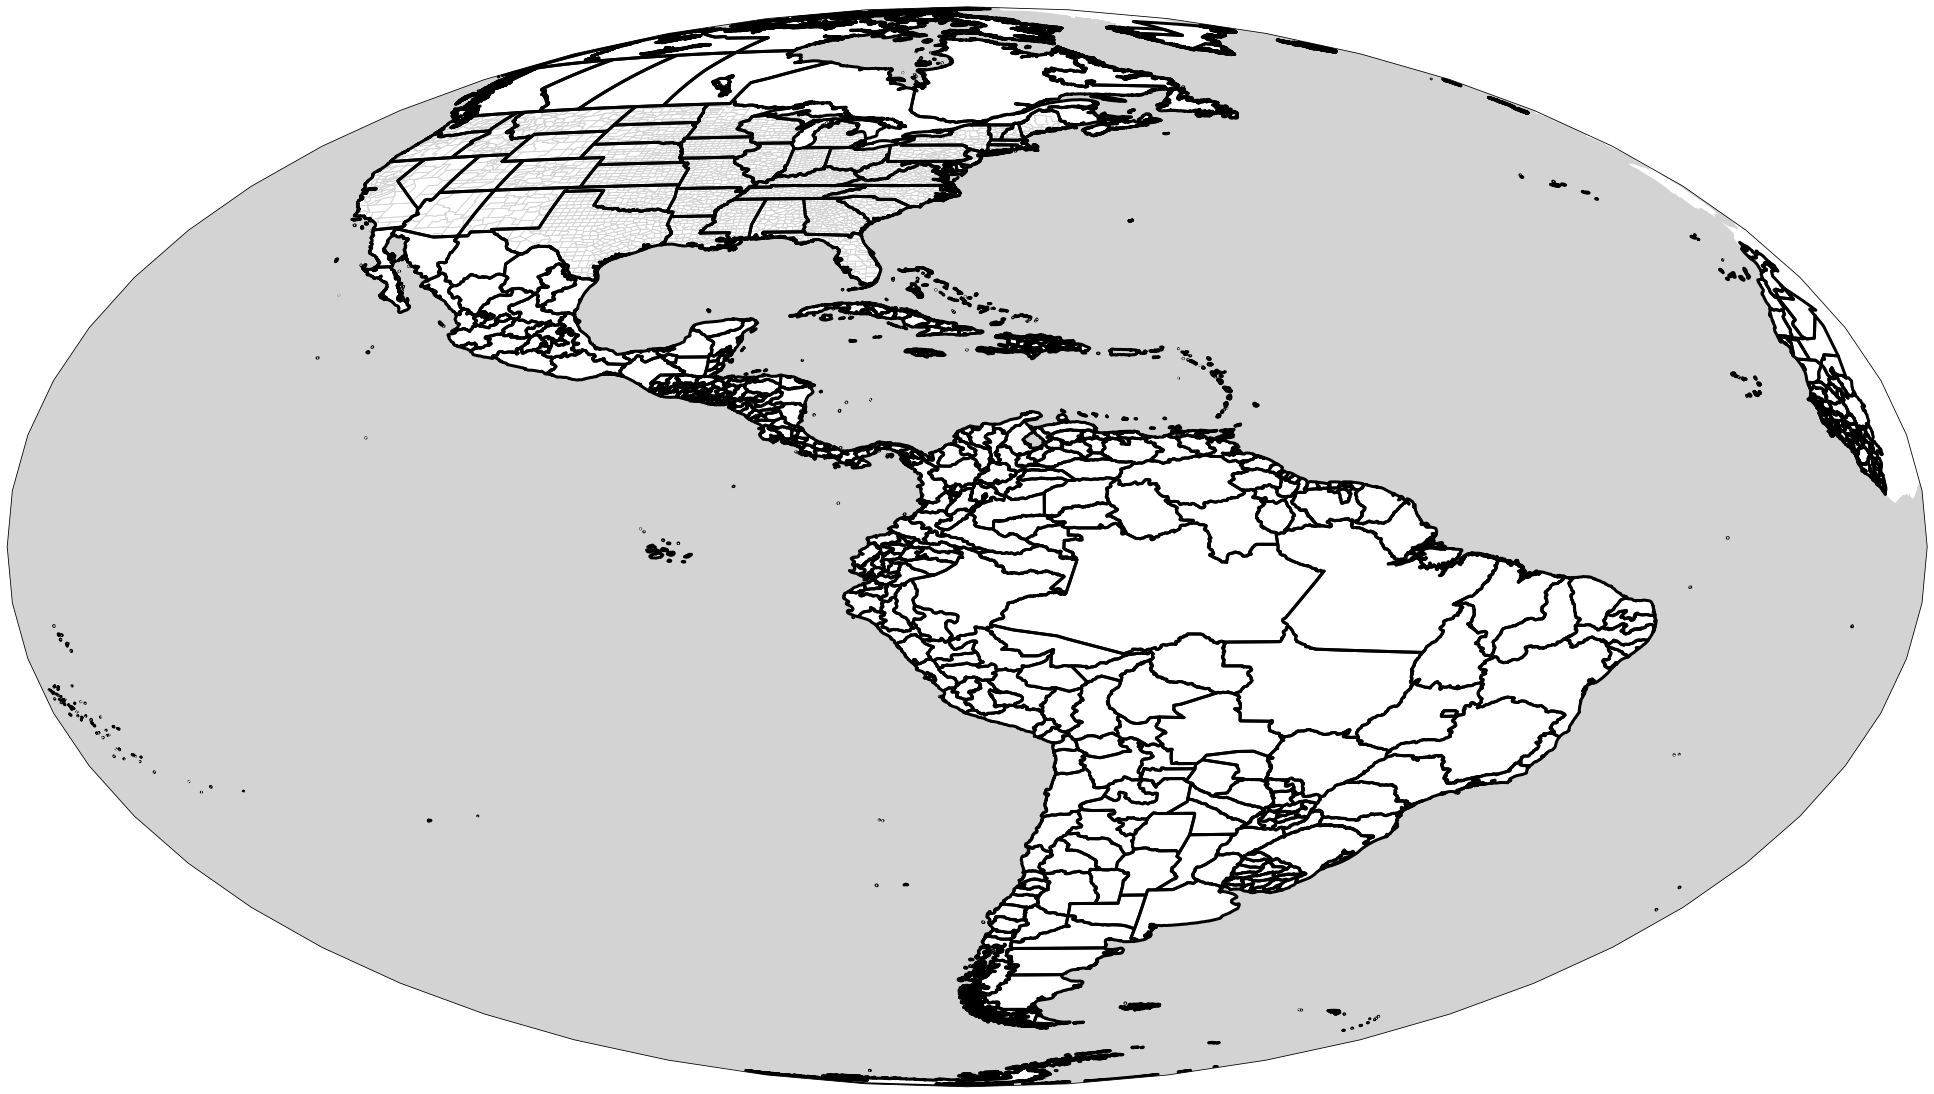

In [5]:
# %%capture
# Grab first dataset and make figure using its projection data
data = datasets[0].metpy.parse_cf('Sectorized_CMI')
proj = data.metpy.cartopy_crs

fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
#ax.set_extent([-85.1, -75, 25.2, 35.5])
#ax.set_extent([-90, -75, 15, 28])
#ax.set_extent([-97, -77, 22, 31]) # Marco
ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=3.0)

ax.set_adjustable('datalim')

cmap = colortables.get_colortable('ir_tv1_r')
# extract all colors from the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
# Make the last color entry to be transparent
cmaplist[-1] = (1, 1, 1, 0)
# create the new colormap
cmap = colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

In [6]:
# Container for the artists of all frames. Each item is a tuple of (image, text)
artists = []

for ds in datasets:
    data = ds.metpy.parse_cf('Sectorized_CMI')
    x = data['x']
    y = data['y']
    
    VALID_TIME = convert_datetime(str(data['time'].values).split('.')[0])
    
    # Create Banner
    banner = ax.text(s=f'GOES-16 Infrared - ABI Channel {CHANNEL}\n{VALID_TIME}', y=0.95, x=0.01, 
                     transform=ax.transAxes, zorder=100, fontname='Arial', color='white',
                     fontweight='bold', fontsize=48, va='top',
                     bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))
    
    # Plot the image
    im = ax.imshow(data, extent=(x.min(), x.max(), y.min(), y.max()),
                   origin='upper', cmap=cmap, vmax=273)
    
    artists.append((banner, im))


In [7]:
# Build and save animation
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'satellite'
anim = ArtistAnimation(fig, artists, interval=200., blit=False)
anim.save(f'{graphics_dir}/channel{CHANNEL}.mp4', writer='ffmpeg')